<a href="https://colab.research.google.com/github/huongnd12/wine-quality-prediction/blob/main/wine_quality_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1.Dataset Introduction

In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/Projects/Wine Quality Prediction/winequality.names', 'r') as f:
  print(f.read())

Citation Request:
  This dataset is public available for research. The details are described in [Cortez et al., 2009]. 
  Please include this citation if you plan to use this database:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

1. Title: Wine Quality 

2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 016

In [51]:
df_white = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Wine Quality Prediction/winequality-white.csv', sep=';')
df_red = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Wine Quality Prediction/winequality-red.csv', sep=';')

df_white['type'] = 1
df_red['type'] = 0

In [52]:
df = pd.concat([df_white, df_red], ignore_index=True)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In this project, I will divide the dataset into 3 classes:
- Poor: quality 3 to 4
- Average: quality 5 to 6
- Good: quality 7 to 9

In [53]:
df['label'] = 0
df.loc[(df['quality'] >= 5) & (df['quality'] < 7), 'label'] = 1
df.loc[df['quality'] >= 7, 'label'] = 2

In [54]:
df[['quality','label']].value_counts().sort_index()

quality  label
3        0          30
4        0         216
5        1        2138
6        1        2836
7        2        1079
8        2         193
9        2           5
dtype: int64

# 2.EDA

*Discover the distribution of classes:*

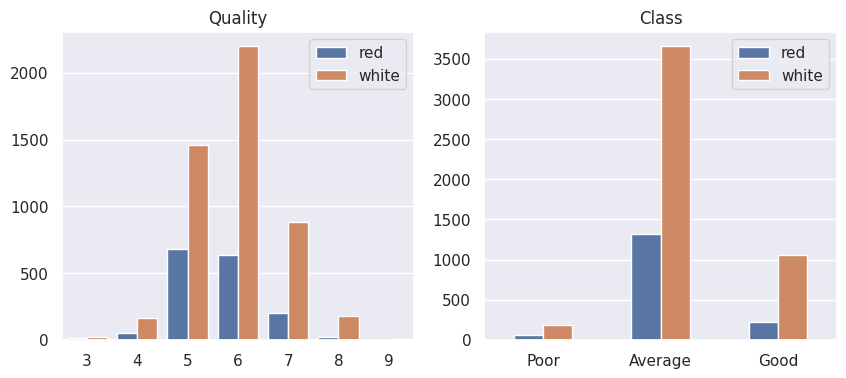

In [55]:
sns.set()
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='quality', hue='type')
plt.legend(['red','white']).set_title('')
plt.xlabel('')
plt.ylabel('')
plt.title('Quality')

plt.subplot(1, 2, 2)
ax = sns.countplot(data=df, x='label', hue='type', width=0.5)
plt.legend(['red','white']).set_title('')
ax.set_xticklabels(['Poor','Average','Good'])
plt.xlabel('')
plt.ylabel('')
plt.title('Class')

plt.show()

The quality classes are ordered and not balanced as there are much more normal wines than excellent or poor ones.

Decision trees frequently perform well on imbalanced data. Tree base algorithm work by learning a hierarchy of if/else questions. This can force both classes to be addressed. Tree ensembles (Random Forests, Gradient Boosted Trees, etc.) almost always outperform singular decision trees, so I will apply tree base algorithm in this project.

*Discover the correlation between features:*

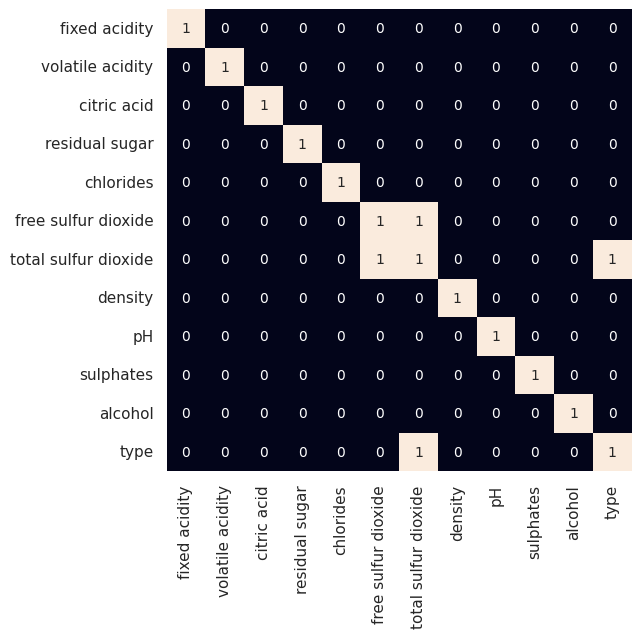

In [56]:
corr_matrix = df.drop(['quality','label'], axis=1).corr()
sns.set()
plt.figure(figsize=(6,6))
fig = sns.heatmap(abs(corr_matrix) > 0.7, annot=True, annot_kws={'size':10}, fmt='d', cbar=False)
plt.show()

In [57]:
corr_matrix.loc[['free sulfur dioxide','total sulfur dioxide','type'], ['free sulfur dioxide','total sulfur dioxide','type']]

,free sulfur dioxide,total sulfur dioxide,type
free sulfur dioxide,1.000000,0.720934,0.471644
total sulfur dioxide,0.720934,1.000000,0.700357
type,0.471644,0.700357,1.000000


`wine type` and `free sulfur dioxide` has relatively high correlation with `total sulfur dioxide`. Redundant features do not help with increasing the model's performance will be removed.

In [58]:
df_end = df.drop(['free sulfur dioxide','type', 'quality'], axis=1)

In [59]:
df_end.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,label
0,7.0,0.27,0.36,20.7,0.045,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,186.0,0.9956,3.19,0.40,9.9,1


# 3.Data Preparation

In [60]:
X = df_end.drop(['label'], axis=1).to_numpy()
y = df_end['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

# 4.Modelling

## 4.1.Random Forest

In [106]:
rf_clf = RandomForestClassifier(max_depth=6, n_estimators=200)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=200)

Training score: 0.8247065614777757
Validation score: 0.7976923076923077
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.81      0.96      0.88       999
           2       0.66      0.30      0.41       253

    accuracy                           0.80      1300
   macro avg       0.49      0.42      0.43      1300
weighted avg       0.75      0.80      0.76      1300



<Axes: >

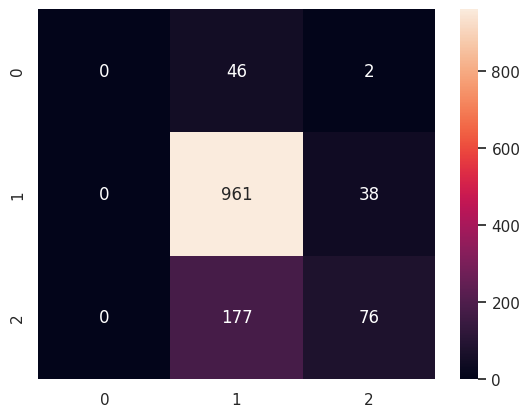

In [107]:
y_pred = rf_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

print('Training score:', rf_clf.score(X_train, y_train))
print('Validation score:', rf_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))

sns.set()
sns.heatmap(cf_matrix, annot=True, fmt='d')

**Feature Importance**

In [108]:
rf_clf.feature_importances_

array([0.04008986, 0.09278723, 0.07133959, 0.06904433, 0.09446701,
       0.06648087, 0.14422906, 0.05506687, 0.06401299, 0.3024822 ])

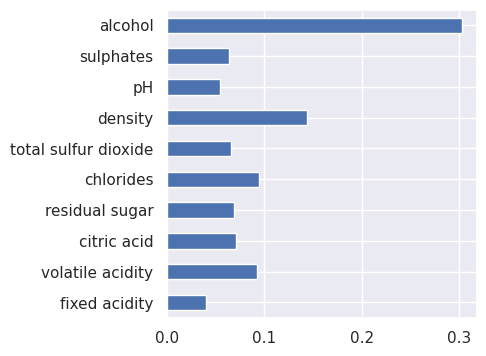

In [109]:
f_names = df_end.columns[:-1]
f_imp = pd.Series(rf_clf.feature_importances_, index=f_names)
plt.figure(figsize=(4,4))
f_imp.plot(kind='barh')
plt.show()

In [110]:
rf_f_names = f_names[np.where(rf_clf.feature_importances_ >= 0.1)[0]].tolist()
print('Select features for Random Forest:')
print(rf_f_names)

Select features for Random Forest:
['density', 'alcohol']


In [112]:
selected_idx = np.where(rf_clf.feature_importances_ >= 0.1)[0]
X_train_2 = X_train[:, selected_idx]
X_test_2 = X_test[:, selected_idx]

In [113]:
rf_clf_2 = RandomForestClassifier(max_depth=6, n_estimators=200)
rf_clf_2.fit(X_train_2, y_train)

RandomForestClassifier(max_depth=6, n_estimators=200)

Training score: 0.7937271502790071
Validation score: 0.7846153846153846
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.80      0.97      0.87       999
           2       0.62      0.21      0.32       253

    accuracy                           0.78      1300
   macro avg       0.47      0.39      0.40      1300
weighted avg       0.73      0.78      0.73      1300



<Axes: >

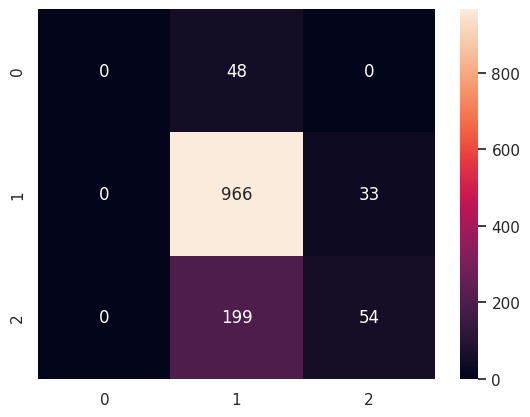

In [114]:
y_pred = rf_clf_2.predict(X_test_2)
cf_matrix = confusion_matrix(y_test, y_pred)

print('Training score:', rf_clf_2.score(X_train_2, y_train))
print('Validation score:', rf_clf_2.score(X_test_2, y_test))
print(classification_report(y_test, y_pred))

sns.set()
sns.heatmap(cf_matrix, annot=True, fmt='d')

## 4.2.XGBoost

In [115]:
xgb_clf = xgboost.XGBClassifier(max_depth=6,
                                n_estimators=200,
                                learning_rate=1000)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1000, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Training score: 0.8287473542428324
Validation score: 0.8
              precision    recall  f1-score   support

           0       0.67      0.04      0.08        48
           1       0.83      0.93      0.88       999
           2       0.61      0.42      0.49       253

    accuracy                           0.80      1300
   macro avg       0.70      0.46      0.48      1300
weighted avg       0.78      0.80      0.77      1300



<Axes: >

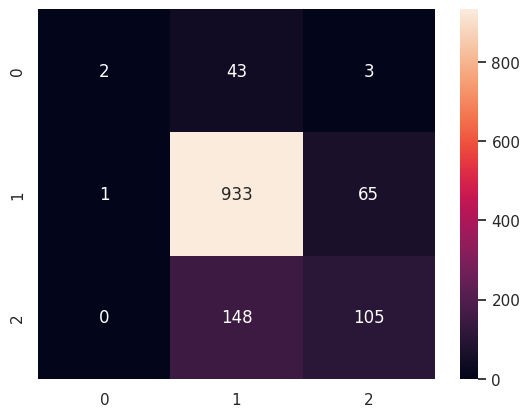

In [116]:
y_pred = xgb_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

print('Training score:', xgb_clf.score(X_train, y_train))
print('Validation score:', xgb_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))

sns.set()
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [117]:
xgb_clf_2 = xgboost.XGBClassifier(max_depth=6,
                                  n_estimators=200,
                                  learning_rate=1000)
rfe = RFE(xgb_clf_2,
          n_features_to_select=5,
          step=1)

rfe.fit(X_train, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=1000, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=6, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=200, n_jobs=None,
                            num_parallel_tree=None, random_state=None, ...),
    n_features_to_select=5)

Training score: 0.820280931306523
Validation score: 0.7976923076923077
              precision    recall  f1-score   support

           0       0.50      0.02      0.04        48
           1       0.82      0.95      0.88       999
           2       0.62      0.36      0.45       253

    accuracy                           0.80      1300
   macro avg       0.65      0.44      0.46      1300
weighted avg       0.77      0.80      0.77      1300



<Axes: >

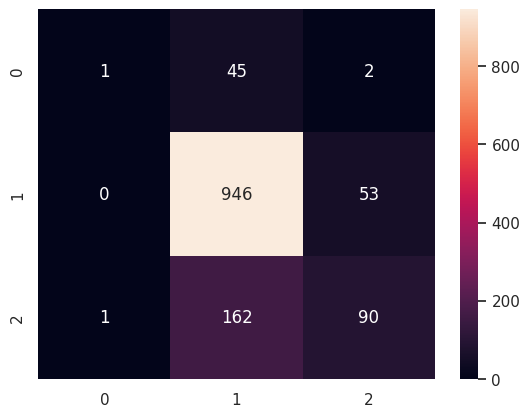

In [118]:
y_pred = rfe.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

print('Training score:', rfe.score(X_train, y_train))
print('Validation score:', rfe.score(X_test, y_test))
print(classification_report(y_test, y_pred))

sns.set()
sns.heatmap(cf_matrix, annot=True, fmt='d')

## 4.3.Summary

In [122]:
model_summary = {'algorithm':['RF','RF','XGB','XGB-RFE'],
                 'feature_name':[f_names.tolist(),
                                 rf_f_names,
                                 f_names.tolist(),
                                 f_names[rfe.support_].tolist()],
                 'training_score':[rf_clf.score(X_train, y_train),
                                   rf_clf_2.score(X_train_2, y_train),
                                   xgb_clf.score(X_train, y_train),
                                   rfe.score(X_train, y_train)],
                 'valid_score':[rf_clf.score(X_test, y_test),
                                rf_clf_2.score(X_test_2, y_test),
                                xgb_clf.score(X_test, y_test),
                                rfe.score(X_test, y_test)],
                 'valid_f1':[f1_score(y_test, rf_clf.predict(X_test), average='macro'),
                             f1_score(y_test, rf_clf_2.predict(X_test_2), average='macro'),
                             f1_score(y_test, xgb_clf.predict(X_test), average='macro'),
                             f1_score(y_test, rfe.predict(X_test), average='macro')]}
df_summary = pd.DataFrame(model_summary)
df_summary

,algorithm,feature_name,training_score,valid_score,valid_f1
0,RF,"[fixed acidity, volatile acidity, citric acid,...",0.824707,0.797692,0.430788
1,RF,"[density, alcohol]",0.793727,0.784615,0.397022
2,XGB,"[fixed acidity, volatile acidity, citric acid,...",0.828747,0.800000,0.483445
3,XGB-RFE,"[volatile acidity, citric acid, chlorides, sul...",0.820281,0.797692,0.457148


All models were used in this project nearly cannot classify correctly any samples from the `Poor` class. The performance for `Good` class classification is not good. This results from the imbalanced data and the number of samples in these 2 classes is not large enough.

Overall, models using XGBoost algorithm gave better perforamce.